# A521/RXCJ0454 Sinfoni Data

- Cubes do not have an associated variance: create a variance spectra
- Correct the cube background
- Mask bad voxels: both in wavelenght and spatial pixels
- Make Pseudo Narrow Bands from SINFONI data

** Right now, we can't compare photometry with HST or NIRC KECK since None of them includes SINFONI wavelenghts**

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook
import matplotlib.pylab as plt
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy import wcs
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.convolution import Gaussian1DKernel,Gaussian2DKernel, convolve
from astropy.modeling import models, fitting
from astropy import units as u
from reproject import reproject_interp, reproject_exact
from lmfit import minimize, Parameters

In [2]:
cube = fits.getdata('../Data/Cubes/087.A-0700_RXCJ0454J.fits')
header = fits.getheader('../Data/Cubes/087.A-0700_RXCJ0454J.fits')
wave = [header['CRVAL3']+i*header['CDELT3'] for i in range(cube.shape[0])] 

def wav2pix(wav):
    return int((wav-header['CRVAL3'])/header['CDELT3'])

# White light
white_im = np.nanmean(cube,axis=0)#np.nanmean(cube[250:trim_pix,:,:],axis=0)

# Noise box
#[12:30,2:20] 

# Variance

Cubes do not have an associated variance. Calculate a variance spectrum by choosing an empty box and calculating the standard deviation for each plane

<IPython.core.display.Javascript object>


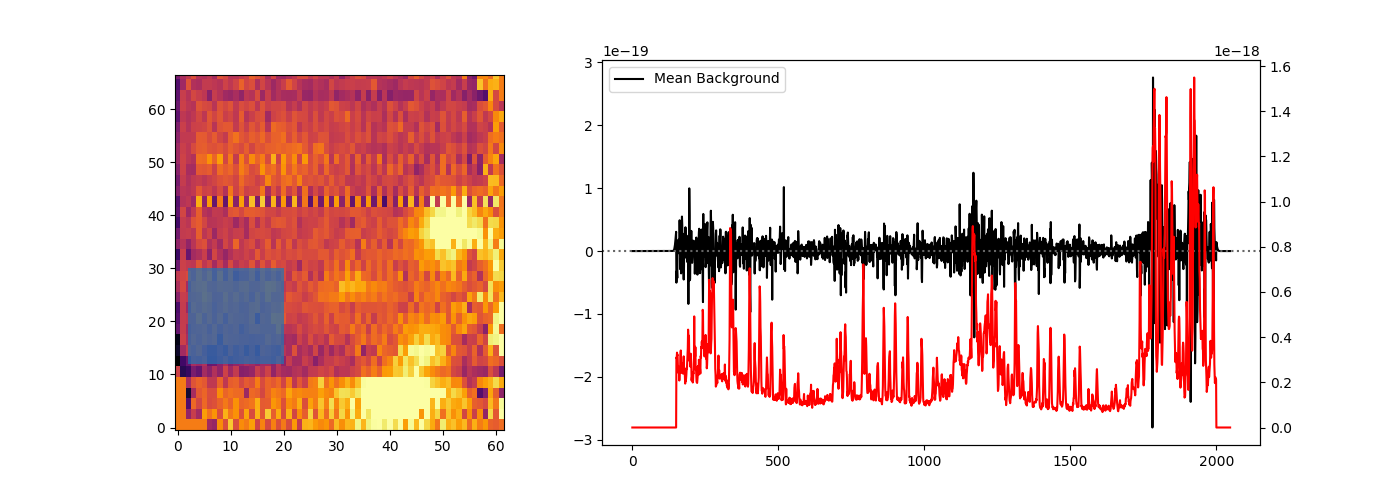

In [5]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

sp_noise = []
sp_background = []

# Noise box
fig, ax = plt.subplots(1,2,figsize=(14,5),gridspec_kw={'width_ratios':[1,2]})
rect = Rectangle((2, 12), 18, 18, alpha=0.7)
ax[0].add_artist(rect)
ax[0].imshow(white_im,cmap=plt.cm.inferno,vmin=-1e-19,vmax=1e-19,origin='lower')

# Spectra
for k in range(cube.shape[0]):
    sp_noise.append(np.nanstd(cube[k,12:30,2:20]))
    sp_background.append(np.nanmean(cube[k,12:30,2:20]))
    
sp_noise = np.array(sp_noise)
sp_background = np.array(sp_background)

ax[1].plot(sp_background,color='k',label='Mean Background')
axt = ax[1].twinx()
axt.plot(sp_noise,color='r',label='Std Background')
ax[1].axhline(0,color='0.4',linestyle=':')
ax[1].legend()

### Save noise spectrum

In [18]:
# Save spectra
prihdr = fits.Header()
prihdr['CRVAL1'] = wave[0]
prihdr['CRPIX1'] = 1
prihdr['CDELT1'] = wave[1]-wave[0]
prihdr['CUNIT1']= 'Angstrom'
fits.writeto('../Data/Spectra/Spectrum_SINFONI_A521_background.fits',sp_background, prihdr,output_verify='fix',clobber=True)
fits.writeto('../Data/Spectra/Spectrum_SINFONI_A521_std.fits',sp_noise, prihdr,output_verify='fix',clobber=True)

### Correct cube by subtracting the backgound in each wavelenght plane

<IPython.core.display.Javascript object>


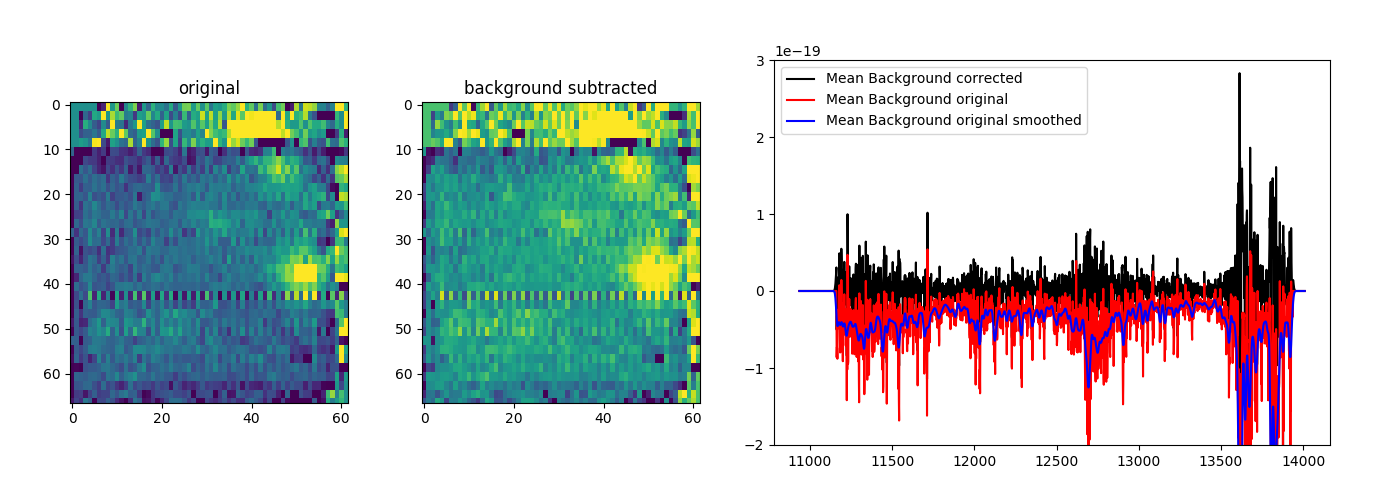

New average background 3.04e-36


In [29]:
# Smooth background spectra to make sure spikes are not subtracted
kernel = Gaussian1DKernel(stddev=4)
sp_bg_smooth = convolve(sp_background, kernel)

#Trim very bad edges and correct cube
bgcorr_cube = []
for k in range(cube.shape[0]):
    bgcorr_cube.append(cube[k,:,:] - sp_bg_smooth[k])
bgcorr_cube = np.array(bgcorr_cube)

# Plotting
fig, ax = plt.subplots(1,3,figsize=(14,5),gridspec_kw={'width_ratios':[1,1,2]})
fig.subplots_adjust(left=0.05,right=0.95)

# Check differences in white light
white_im_bgcorr = np.nanmean(bgcorr_cube,axis=0)
ax[0].imshow(white_im,vmin=-1e-19,vmax=1e-19)
ax[1].imshow(white_im_bgcorr,vmin=-1e-19,vmax=1e-19)
ax[0].set_title('original')
ax[1].set_title('background subtracted')

# Extract new background and noise spectra to check
sp_noise_check = []
sp_background_check = []
for k in range(bgcorr_cube.shape[0]):
    sp_noise_check.append(np.nanstd(bgcorr_cube[k,12:30,2:20]))
    sp_background_check.append(np.nanmean(bgcorr_cube[k,12:30,2:20]))
ax[2].plot(wave,sp_background_check,color='k',label='Mean Background corrected')
ax[2].plot(wave,sp_background,color='r',label='Mean Background original')
ax[2].plot(wave,sp_bg_smooth,color='b',label='Mean Background original smoothed')

ax[2].set_ylim(-2e-19,3e-19)
ax[2].legend()

print('New average background %0.2e'%np.nanmean(sp_background_check))
fits.writeto('../Data/Cubes/Cube_SINFONI_A521_background_corrected.fits',bgcorr_cube, header,output_verify='fix',clobber=True)

##  Clip bad pixels

('bg corr: STD all', 2.9060941248354453e-18, ' empty box', 4.768346937689172e-19)
('clipped: STD all', 3.7459366088043376e-19, ' empty box', 3.227965405180019e-19)


<IPython.core.display.Javascript object>


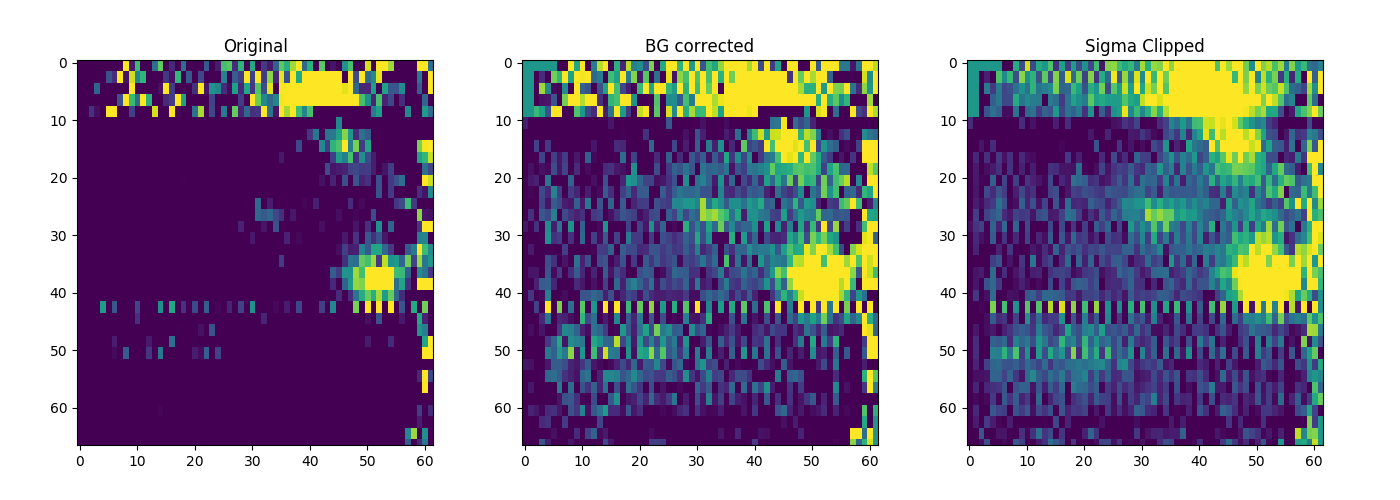

In [35]:
# Make white light but with sigma clipping
clip_cube = sigma_clip(bgcorr_cube,sigma=7,iters=5,cenfunc=np.ma.median,stdfunc=np.std)
clip_white_im = np.ma.mean(clip_cube,axis=0)

## Some stats
print('bg corr: STD all',np.nanstd(bgcorr_cube),' empty box',np.nanstd(bgcorr_cube[:,12:30,2:20]))
print('clipped: STD all',np.nanstd(clip_cube),' empty box',np.nanstd(clip_cube[:,12:30,2:20]))

fig, ax = plt.subplots(1,3,figsize=(14,5))
fig.subplots_adjust(left=0.05,right=0.95)

ax[0].imshow(white_im,vmin=0,vmax=0.8e-19)
ax[1].imshow(white_im_bgcorr,vmin=0,vmax=0.8e-19)
ax[2].imshow(clip_white_im.data,vmin=0,vmax=0.8e-19)

ax[0].set_title('Original')
ax[1].set_title('BG corrected')
ax[2].set_title('Sigma Clipped')

In [36]:
# Save cube
header_cube = header.copy()
header_cube['NAXIS'] = 3
header_cube['NAXIS3'] = len(wave)
header_cube['CRVAL3'] = wave[0]
header_cube['CRPIX3'] = 1
header_cube['CDELT3'] = wave[1]-wave[0]
header_cube['CUNIT3']= 'Angstrom'
header_cube['SIGCLIP']= 7
header_cube['SIGAXIS'] = 3

# masked arrays are still not emplemented. put mask to nan
clip_cube[np.where(clip_cube.mask==True)]  = np.nan

fits.writeto('../Data/Cubes/Cube_SINFONI_A521_background_corrected_clipped.fits',clip_cube.data, header,output_verify='fix',clobber=True)

# Check phometry

So far, we cannot do this because there is no data availabel

## H$\alpha$ narrow band and Spectra

Now that the cube is a bit cleaner, we extract the integrated spectra. We do so using the MUSE apperture and an "optimal" aperture from SINFONI.

The optimal aperture is define in white/Ha pseudo-narrow band as 3 sigma above background.


In [3]:
Halpha = 6562.8 #A
z = 1.0436 # From the MUSE spectra
cube = fits.getdata('../Data/Cubes/Cube_SINFONI_A521_background_corrected_clipped.fits')

<IPython.core.display.Javascript object>


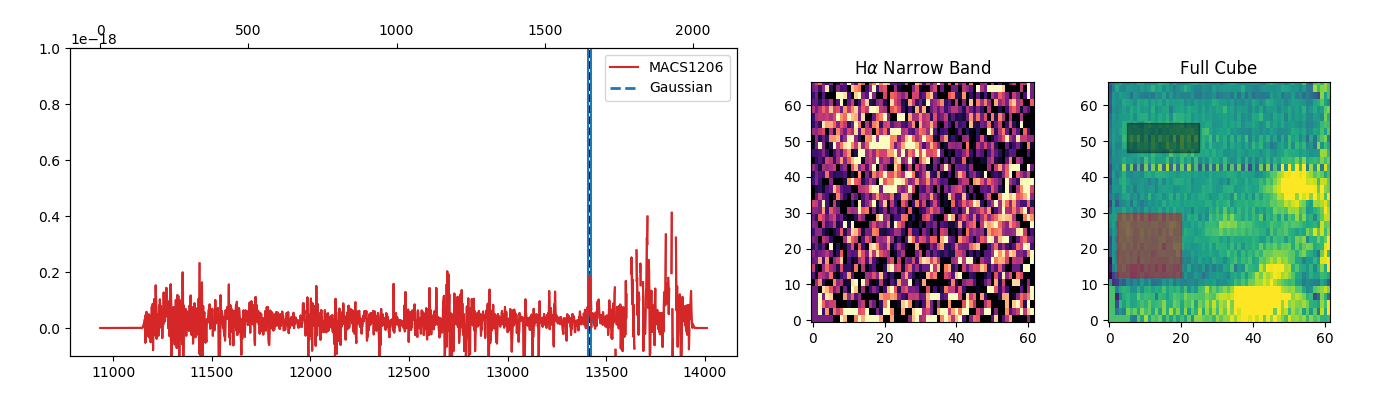

In [6]:
# Spectrum from box in the snake
sp_box = np.mean(cube[:,47:55,5:25],axis=(1,2))

# Fit Halpha spectrum
gauss = models.Gaussian1D(amplitude=1.7e-19, mean=wave[1652], stddev=4)
const = models.Const1D(amplitude=2e-20)
model = gauss+const
#fit_Ha = fitting.LevMarLSQFitter() # It isn't fitting
#gauss_fit = fit_Ha(model, wave_trim[1350:1390], sp_box[1350:1390])
#print(gauss_fit)

# Make narrow band image --> Use 3 sigma from Ha and subtract continuum
def make_nb(cube,center,width,red=None,blue=None):
    """Makes a narrow band around pixel center and width 3*sigma, subtracting the
    continuum extrapolated from red_cont and blue_cont"""
    
    if red is None:
        red = center+4*width, center+6*width
    if blue is None:
        blue = center-6*width, center-4*width
    imblue = np.nanmean(cube[blue[0]:blue[1]],axis=0)
    imred = np.nanmean(cube[red[0]:red[1]],axis=0)
    m = (imred - imblue)/((red[0]+red[1])/2 - (blue[0]+blue[1])/2)
    a = imred - m*(red[0]+red[1])/2
    dummy = np.empty_like(cube)
    for k in range(center-3*width,center+3*width+1):
        dummy[k,:,:] = cube[k,:,:] - (m*k + a)

    return np.nanmean(dummy[center-3*width:center+3*width],axis=0)*(wave[1]-wave[0])
    
    
nb_im = make_nb(cube,center=1652,width=2)
white_im = np.nanmean(cube,axis=0)

# Plot Spectra
fig, ax  = plt.subplots(1,3,figsize=(14,4),gridspec_kw={'width_ratios':[3,1,1]})
fig.subplots_adjust(left=0.05,right=0.95)
ax[0].axvline(Halpha*(1+z),color='k',linestyle='--')
ax_t = ax[0].twiny()
ax_t.axvline(1652-6)
ax_t.axvline(1652+6)
ax_t.plot(sp_box,color='C3',label='MACS1206')
ax[0].plot(wave,sp_box,color='C3',label='MACS1206')
ax[0].plot(wave[1640:1665], model(wave[1640:1665]), label='Gaussian',linestyle='--',linewidth=2.)
ax[0].legend()
ax[0].set_ylim((-1e-19,1e-18))

# Plot Narrow band
ax[1].imshow(nb_im, origin='lower', cmap=plt.cm.magma,vmin=-1e-19, vmax=2e-19)
ax[1].set_title('H$\\alpha$ Narrow Band')

ax[2].imshow(white_im, origin='lower', cmap=plt.cm.viridis,vmin=-1e-19, vmax=1e-19)
ax[2].set_title('Full Cube')
ax[2].add_artist(Rectangle((2, 12), 18, 18,color='r',alpha=0.4))
ax[2].add_artist(Rectangle((5, 47), 20, 8,color='k',alpha=0.4))

<IPython.core.display.Javascript object>


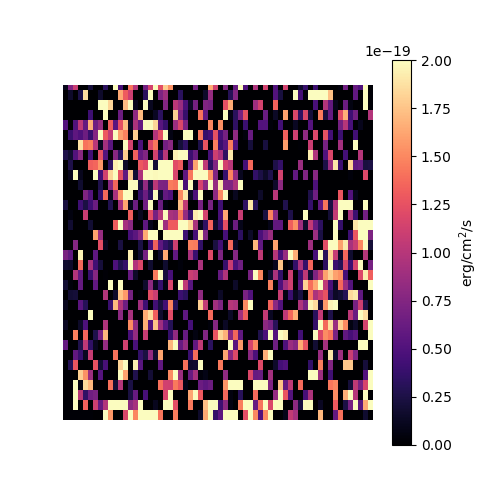

In [14]:
## Dummy plot for paper
fig, ax = plt.subplots(1,1,figsize=(5,5))
cax = ax.imshow(nb_im, origin='lower', cmap=plt.cm.magma,vmin=0e-19, vmax=2e-19)
plt.colorbar(cax,label='erg/cm$^2$/s')
ax.axis('off')
fig.savefig('/Users/vera/Desktop/A521-Ha.pdf')

In [ ]:
## Extract Spectrum

<IPython.core.display.Javascript object>


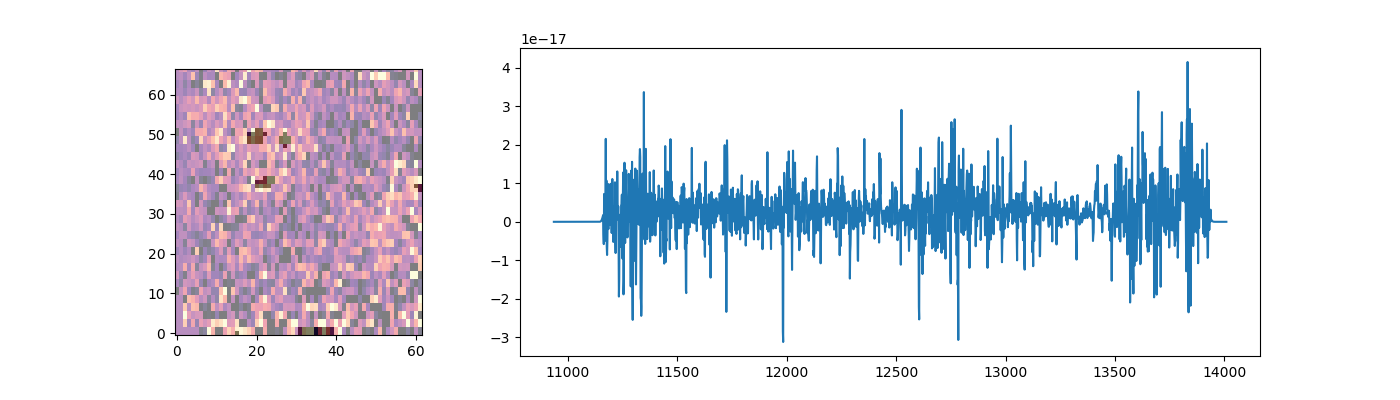

In [77]:
cube = fits.getdata('../Data/Cubes/Cube_SINFONI_A521_background_corrected_clipped.fits')

# Select background box
mean, median, std = sigma_clipped_stats(nb_im,sigma=3,iters=5)

# Mask
mask = nb_im.copy()
smooth = ndimage.gaussian_filter(nb_im, sigma=(2,2), order=0)
mask[:,:] = 1.0
mask[np.where(smooth > mean+std)]= 0 # or np.nan
#mask[120:,:] = 1
mask_pix = np.where(mask == 1) # masked out

# Extract Spectra
masked_cube = np.empty_like(cube)
for k in range(cube.shape[0]):
    dummy = cube[k,:,:]
    dummy[mask_pix] = np.nan
    masked_cube[k,:,:] = dummy
sp = np.nansum(masked_cube,axis=(1,2))


# Plot
fig, ax = plt.subplots(1,2,gridspec_kw={'width_ratios':[1,3]},figsize=(14,4))
ax[0].imshow(nb_im, origin='lower', cmap=plt.cm.magma,vmin=-1e-19, vmax=2e-19)
ax[0].imshow(mask,vmin=0,vmax=1e-19,alpha=0.5,cmap=plt.cm.Greys_r,origin='lower')
ax[1].plot(wave,sp)

# Save mask
#fits.writeto('../Data/NarrowBands/Mask_MACS1206_Ha.fits',mask, header,output_verify='fix',clobber=True)
#fits.writeto('../Data/NarrowBands/Image_MACS1206_Ha.fits',nb_im, header,output_verify='fix',clobber=True)
#fits.writeto('../Data/Spectra/Spectrum_SINFONI_MACS1206_Ha_aperture.fits',sp, prihdr,output_verify='fix',clobber=True)